In [31]:
import yfinance as yf
import pandas as pd

def get_stock_data_list(stock_codes, period='1y'):
    all_stock_data = []

    for stock_code in stock_codes:
        try:
            yahoo_ticker = stock_code + '.NS'
            stock = yf.Ticker(yahoo_ticker)
            data = stock.history(period=period)
            if not data.empty:
                # Extract relevant features from historical stock data
                stock_data = {
                    'Date': data.index.tolist(),
                    'Ticker': [stock_code] * len(data),
                    'Open': data['Open'].tolist(),
                    'High': data['High'].tolist(),
                    'Low': data['Low'].tolist(),
                    'Close': data['Close'].tolist(),
                    'Volume': data['Volume'].tolist(),
                    'Sector': [stock.info.get('industry', 'N/A')] * len(data)  # Added safely
                }
                all_stock_data.append(pd.DataFrame(stock_data))
            else:
                print(f"No data available for {stock_code}")
        except Exception as e:
            print(f"Error fetching data for {stock_code}: {e}")

    if all_stock_data:
        return pd.concat(all_stock_data, ignore_index=True)
    else:
        print("No stock data fetched.")
        return pd.DataFrame()

# Example usage:
duration_period = '1y'  # Change the duration as needed

# My Picks
stock_codes_list = ['EDELWEISS', 'JIOFIN','SYNCOMF','GREENPOWER','SALASAR','COMFINTE','MISHTANN']

stock_data_df = get_stock_data_list(stock_codes_list, period=duration_period)

# Display the DataFrame
stock_data_df

$COMFINTE.NS: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")


No data available for COMFINTE


$MISHTANN.NS: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")


No data available for MISHTANN


,Date,Ticker,Open,High,Low,Close,Volume,Sector
0,2023-10-04 00:00:00+05:30,EDELWEISS,62.076886,67.118164,61.038977,65.190613,55532179,Capital Markets
1,2023-10-05 00:00:00+05:30,EDELWEISS,66.129681,75.619141,65.734286,73.049080,69442555,Capital Markets
2,2023-10-06 00:00:00+05:30,EDELWEISS,74.630648,76.162804,67.760678,68.996284,28423967,Capital Markets
3,2023-10-09 00:00:00+05:30,EDELWEISS,68.205498,68.205498,64.251556,65.635437,7160960,Capital Markets
4,2023-10-10 00:00:00+05:30,EDELWEISS,66.722771,67.167586,64.844647,65.437737,3060490,Capital Markets
...,...,...,...,...,...,...,...,...
1223,2024-09-27 00:00:00+05:30,SALASAR,19.959999,20.230000,19.520000,19.559999,12553097,Steel
1224,2024-09-30 00:00:00+05:30,SALASAR,19.559999,19.790001,18.600000,18.820000,25090972,Steel
1225,2024-10-01 00:00:00+05:30,SALASAR,18.860001,20.190001,18.809999,19.680000,15418475,Steel
1226,2024-10-03 00:00:00+05:30,SALASAR,19.420000,19.549999,18.799999,19.030001,12141068,Steel


In [32]:
stock_data_df.Ticker.value_counts()

Ticker
EDELWEISS     246
SYNCOMF       246
GREENPOWER    246
SALASAR       246
JIOFIN        244
Name: count, dtype: int64

In [33]:
# Group by Ticker and calculate the requested statistics
ticker_grouped = stock_data_df.groupby('Ticker')
agg_functions = {
    'Close': ['min', 'max', 'median', 'mean', 'var', 'std']
}

stock_summary = ticker_grouped.agg(agg_functions).reset_index()

# Flatten the multi-level columns
stock_summary.columns = ['{}_{}'.format(col[0], col[1]) for col in stock_summary.columns]
stock_summary = stock_summary.rename(columns={'Ticker_': 'Ticker'})

# Display the summary DataFrame
stock_summary

,Ticker,Close_min,Close_max,Close_median,Close_mean,Close_var,Close_std
0,EDELWEISS,59.160854,142.050003,72.431274,77.214231,344.962212,18.573158
1,GREENPOWER,12.650000,32.849998,21.035000,20.927485,10.171549,3.189287
2,JIOFIN,206.600006,387.950012,329.475006,305.101640,3187.821235,56.460794
3,SALASAR,9.020000,33.950001,19.110000,18.000366,28.952712,5.380772
4,SYNCOMF,8.000000,26.770000,13.450000,14.248740,14.377223,3.791731


In [34]:
# Left join the ticker_features DataFrame with the original stock_data_df DataFrame
merged_df = pd.merge(stock_data_df, stock_summary, on='Ticker', how='left')

merged_df['Close_z_score'] = (merged_df['Close'] - merged_df['Close_mean']) / merged_df['Close_std']

# Format the 'Date' column
merged_df['Date'] = merged_df['Date'].dt.strftime('%Y-%m-%d')
merged_df['Date'] = pd.to_datetime(merged_df['Date'])

# Define the conditions and corresponding values for the new column
conditions = [
    (merged_df['Close_z_score'] <= 1) & (merged_df['Close_z_score'] >= -1),
    (merged_df['Close_z_score'] <= 2) & (merged_df['Close_z_score'] >= -2),
    (merged_df['Close_z_score'] <= 3) & (merged_df['Close_z_score'] >= -3),
    (merged_df['Close_z_score'] > 3) & (merged_df['Close_z_score'] < -3),
]

# Define corresponding values for each condition
values = ['Within_1', 'Within_2', 'Within_3', 'More_3']

# Create the new column based on the conditions
merged_df['ZScore_Category'] = np.select(conditions, values, default='Other')


# Sort the DataFrame by 'Ticker' and 'Date'
merged_df = merged_df.sort_values(by=['Ticker', 'Date'], ascending=[True, False]).reset_index(drop=True)

# Display the merged DataFrame
merged_df.head()

,Date,Ticker,Open,High,Low,Close,Volume,Sector,Close_min,Close_max,Close_median,Close_mean,Close_var,Close_std,Close_z_score,ZScore_Category
0,2024-10-04,EDELWEISS,132.100006,132.880005,120.250000,121.349998,10028123,Capital Markets,59.160854,142.050003,72.431274,77.214231,344.962212,18.573158,2.376320,Within_3
1,2024-10-03,EDELWEISS,135.050003,138.500000,131.009995,132.899994,8044424,Capital Markets,59.160854,142.050003,72.431274,77.214231,344.962212,18.573158,2.998185,Within_3
2,2024-10-01,EDELWEISS,142.899994,143.949997,136.149994,140.830002,5709002,Capital Markets,59.160854,142.050003,72.431274,77.214231,344.962212,18.573158,3.425146,Other
3,2024-09-30,EDELWEISS,139.000000,145.529999,138.000000,142.050003,6872099,Capital Markets,59.160854,142.050003,72.431274,77.214231,344.962212,18.573158,3.490832,Other
4,2024-09-27,EDELWEISS,139.000000,143.000000,134.000000,140.130005,11096582,Capital Markets,59.160854,142.050003,72.431274,77.214231,344.962212,18.573158,3.387457,Other


In [35]:
# Subset only one row for each Ticker with Max Date
max_date_indices = merged_df.groupby('Ticker')['Date'].idxmax()
subset_df = merged_df.loc[max_date_indices]
subset_df = subset_df.reset_index(drop=True)
subset_df.shape
subset_df.head()

,Date,Ticker,Open,High,Low,Close,Volume,Sector,Close_min,Close_max,Close_median,Close_mean,Close_var,Close_std,Close_z_score,ZScore_Category
0,2024-10-04,EDELWEISS,132.100006,132.880005,120.250000,121.349998,10028123,Capital Markets,59.160854,142.050003,72.431274,77.214231,344.962212,18.573158,2.376320,Within_3
1,2024-10-04,GREENPOWER,20.350000,21.000000,19.809999,20.180000,12257369,Utilities - Independent Power Producers,12.650000,32.849998,21.035000,20.927485,10.171549,3.189287,-0.234374,Within_1
2,2024-10-04,JIOFIN,343.500000,345.299988,336.500000,338.799988,18945510,Asset Management,206.600006,387.950012,329.475006,305.101640,3187.821235,56.460794,0.596845,Within_1
3,2024-10-04,SALASAR,19.040001,19.549999,18.600000,19.230000,11652353,Steel,9.020000,33.950001,19.110000,18.000366,28.952712,5.380772,0.228524,Within_1
4,2024-10-04,SYNCOMF,21.090000,21.490000,20.340000,20.860001,5852375,Drug Manufacturers - Specialty & Generic,8.000000,26.770000,13.450000,14.248740,14.377223,3.791731,1.743600,Within_2


In [36]:
# Define a function to calculate RSI
def calculate_rsi(data, column='Close', period=14):
    # Calculate daily price changes
    delta = data[column].diff(1)

    # Calculate gains (positive changes) and losses (negative changes)
    gains = delta.where(delta > 0, 0)
    losses = -delta.where(delta < 0, 0)

    # Calculate average gains and losses over the specified period
    avg_gains = gains.rolling(window=period, min_periods=1).mean()
    avg_losses = losses.rolling(window=period, min_periods=1).mean()

    # Calculate relative strength (RS)
    rs = avg_gains / avg_losses

    # Calculate RSI
    rsi = 100 - (100 / (1 + rs))

    return rsi

In [39]:
# Calculate RSI and add it to the DataFrame
#stock_data_df = merged_df[merged_df.Ticker=='EDELWEISS']
stock_data_df = merged_df
stock_data_df['RSI'] = calculate_rsi(stock_data_df)
stock_data_df = pd.DataFrame(stock_data_df)
stock_data_df.head()

,Date,Ticker,Open,High,Low,Close,Volume,Sector,Close_min,Close_max,Close_median,Close_mean,Close_var,Close_std,Close_z_score,ZScore_Category,RSI
0,2024-10-04,EDELWEISS,132.100006,132.880005,120.250000,121.349998,10028123,Capital Markets,59.160854,142.050003,72.431274,77.214231,344.962212,18.573158,2.376320,Within_3,NaN
1,2024-10-03,EDELWEISS,135.050003,138.500000,131.009995,132.899994,8044424,Capital Markets,59.160854,142.050003,72.431274,77.214231,344.962212,18.573158,2.998185,Within_3,100.000000
2,2024-10-01,EDELWEISS,142.899994,143.949997,136.149994,140.830002,5709002,Capital Markets,59.160854,142.050003,72.431274,77.214231,344.962212,18.573158,3.425146,Other,100.000000
3,2024-09-30,EDELWEISS,139.000000,145.529999,138.000000,142.050003,6872099,Capital Markets,59.160854,142.050003,72.431274,77.214231,344.962212,18.573158,3.490832,Other,100.000000
4,2024-09-27,EDELWEISS,139.000000,143.000000,134.000000,140.130005,11096582,Capital Markets,59.160854,142.050003,72.431274,77.214231,344.962212,18.573158,3.387457,Other,91.511945


In [40]:
from telegram import Update
from telegram.ext import ApplicationBuilder, CommandHandler, ContextTypes

ModuleNotFoundError: No module named 'telegram'

[*********************100%***********************]  1 of 1 completed
C:\Users\Abhishek_Jaiswal\AppData\Local\miniconda3\envs\mlenv2\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


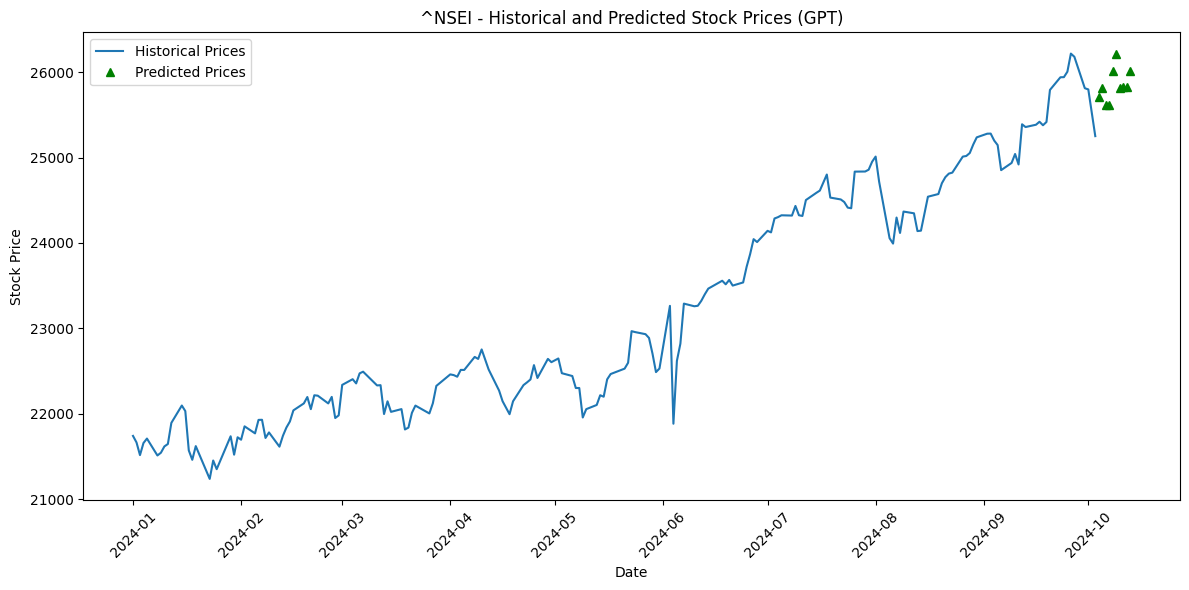

In [14]:
import yfinance as yf
import numpy as np
import pandas as pd  # For handling time series data and dates
import matplotlib.pyplot as plt
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Download stock data
ticker = "^NSEI"
start_date = "2024-01-01"
end_date = "2024-10-04"
data = yf.download(ticker, start=start_date, end=end_date)

# Extract 'Close' prices and convert to strings
prices = data["Close"].tolist()
prices_as_strings = [f'{price:.2f}' for price in prices]  # Format to two decimal places

# Initialize the tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Add pad token if not present in the tokenizer (important for padding)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model = GPT2LMHeadModel.from_pretrained("gpt2")

# Convert price strings into a single text sequence, then tokenize
encoded_prices = tokenizer(" ".join(prices_as_strings), return_tensors="pt", padding=True).input_ids

# Ensure token embeddings match the tokenizer size
model.resize_token_embeddings(len(tokenizer))

# Define a function to generate prices with retries
def generate_prices(encoded_prices, retries=3, max_gen_length=50):
    for attempt in range(retries):
        # Generate future prices with sampling enabled for diversity
        generated = model.generate(
            encoded_prices, 
            max_length=encoded_prices.size(1) + max_gen_length,  # Generate more tokens
            temperature=1.2,  # Increase temperature for diversity
            num_return_sequences=1,
            do_sample=True,  # Enable sampling
            pad_token_id=tokenizer.pad_token_id
        )
        
        # Decode generated tokens into text and attempt to parse them as float prices
        generated_text = tokenizer.decode(generated[0], skip_special_tokens=True)
        generated_prices = []
        for token in generated_text.split():
            try:
                # Convert tokens to float (if possible)
                generated_prices.append(float(token))
            except ValueError:
                # Skip tokens that cannot be converted to a float
                continue

        # If enough valid prices are generated, return them
        if len(generated_prices) >= len(prices) + 10:
            return generated_prices
    
    # If after retries not enough valid prices are generated, raise an error
    raise ValueError("Not enough valid prices generated, even after multiple retries.")

# Generate prices
generated_prices = generate_prices(encoded_prices)

# Plot historical and generated prices
plt.figure(figsize=(12, 6))
plt.plot(data.index, prices, label="Historical Prices")

# Generate future dates for plotting predicted prices
future_dates = pd.date_range(data.index[-1], periods=11, freq='D')[1:]  # Next 10 days after last date

# Plot the predicted prices
plt.plot(
    future_dates, 
    generated_prices[len(prices):len(prices) + 10],  # Only use future prices
    "g^", 
    label="Predicted Prices"
)

# Add labels, title, and legend
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title(f"{ticker} - Historical and Predicted Stock Prices (GPT)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
from llama_index.llms import Ollama

# Initialize the LLM model
llm = Ollama(model="mistral")

# Function to generate a report from the DataFrame
def generate_report(dataframe):
    # Convert DataFrame to string
    df_str = dataframe.to_string(index=False)
    
    # Create a prompt for the LLM
    prompt = f"""
    Create a detailed report based on the following sales data:

    {df_str}

    Please summarize key insights, trends, and recommendations.
    """
    
    # Get the response from the LLM
    resp = llm.complete(prompt)
    return resp

# Generate the report
report = generate_report(df)
print(report)